### **Customer Segmentation by Using RFM Method**

According to [Investopedia](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp), Recency, Frequency, Monetary value is used as a marketing analysis tool to identify a company's customers by analyzing their spending habits. This method can help turn occasional customers into regular ones, predict which customers are likely to repurchase, and how much revenue comes from new and repeat customers. 

The RFM segmentation is based on three quantitative factors as its name:
1. **Recency**: how recently a customer has made a purchase.
2. **Frequency**: how often a customer makes a purchase.
3. **Monetary**: how much money a customer has spent on purchases.

In addition, the RFM metrics also have a relationship with customer lifetime value (frequency and monetary) and engagement rate (Recency).

In this notebook, I use the famous online retail dataset from UCI to apply this RFM method.


**Data source:**

[UCI Online retail dataset](https://archive.ics.uci.edu/ml/datasets/online+retail)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
df = pd.read_excel('Online Retail.xlsx', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


**Attribute Information:**

- **InvoiceNo:** Invoice number. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
- **StockCode:** Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. 
- **Description:** Product (item) name.
- **Quantity:** The quantities of each product (item) per transaction. 
- **InvoiceDate:** Invoice date and time. The day and time when a transaction was generated.
- **UnitPrice:** Product price per unit in pound sterling (£). 
- **CustomerID:** Customer number. A 5-digit integral number uniquely assigned to each customer.
- **Country:** Country name. The name of the country where a customer resides.

### **Exploring Data**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
# Converting the 'CustomerID' column to object data type
df['CustomerID'] = df['CustomerID'].astype('object')

In [5]:
# Formatting Invoice date into y-m-d
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%Y-%m-%d')
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [6]:
# Percentage of missing value in each of features
round(df.isnull().mean()*100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

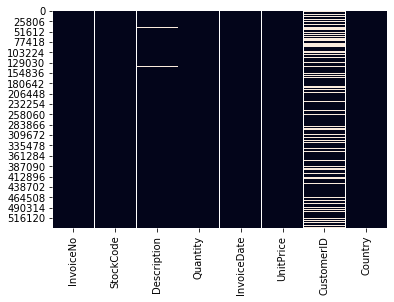

In [7]:
sns.heatmap(df.isnull(), cbar=False);

Two features have missing values. According to the plot, missing value in CustomerID spreads everywhere. Therefore, we need to explore the missing values further before we handle them.

In [8]:
df.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [9]:
num_features = [x for x in df.columns if ((df[x].dtypes == 'int64') | (df[x].dtypes == 'float64'))]
features = df[['Description', 'Quantity', 'CustomerID', 'Country']]

for i in features:
    print(f'Total unique value in {i} is {len(df[i].unique())}')

Total unique value in Description is 4224
Total unique value in Quantity is 722
Total unique value in CustomerID is 4373
Total unique value in Country is 38


The clients came from 38 different countries, and 4224 different types of items have been sold. At least from 01/12/2010 to 09/12/2011, 4373 customers had transactions from the online retail store. However, due to much missing value in CustomerID (4373 missing data), we can not precisely know how many more clients the store had.

### **UnitPrice**

In [10]:
df['UnitPrice'].describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

The minimum price is a negative number and does not make sense. Furthermore, it is interesting to note that 75% of items sold have a unit price below 4.13. On the other hand, the maximum price is 38970. Is it valid? We need to explore it further to know what item it is and how many items have high prices.

In [11]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12,-11062.06,NaN,United Kingdom


Only two transactions have negative prices. According to the description, it seems not a purchase but debt adjustments. How about UnitPrice = 0? Are there UnitPrice equals to 0? Let's check it out.

In [12]:
df[df['UnitPrice'] == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08,0.0,NaN,United Kingdom
538554,581408,85175,NaN,20,2011-12-08,0.0,NaN,United Kingdom


Surprisingly, 2515 data have UnitPrice = 0. Most of the item descriptions are unclear, and the CustomerID values are missing. Thus, it is also better to drop these rows.

In [13]:
# Examine UnitPrice in the top quartile

price_top = df[df['UnitPrice'] > 4.13]
price_top['UnitPrice'].describe()

count    128915.000000
mean         13.794045
std         193.243797
min           4.140000
25%           4.950000
50%           6.750000
75%           8.950000
max       38970.000000
Name: UnitPrice, dtype: float64

In the top quartile of whole data, 75% of data still has a price below 9. It indicated that some transactions must have high prices since the max price is 38970. Overall, the UnitPrice is less than 10. Next, we have to check the transactions with a high price.

In [14]:
df.nlargest(20, 'UnitPrice')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,2011-06-10,38970.00,15098.0,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05,17836.46,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05,16453.71,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07,13541.33,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07,13474.79,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,2011-12-05,11586.50,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12,11062.06,NaN,United Kingdom


The 20 most significant transactions seem to have patterns in their description and stock code. Most of them are Amazon fee, Postage, Manual, and adjust bad debt. Furthermore, most of these transactions also have a negative quantity, which is -1. Is it a typical transaction or another kind of transaction?

To explore it more detail, we can check the data that have a unit price greater than 300.


In [15]:
high_price = df[df['UnitPrice'] > 300]
high_price

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,2010-12-01,569.77,NaN,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,2010-12-01,607.49,NaN,United Kingdom
5685,536865,DOT,DOTCOM POSTAGE,1,2010-12-03,498.47,NaN,United Kingdom
6165,536876,DOT,DOTCOM POSTAGE,1,2010-12-03,887.52,NaN,United Kingdom
10812,537237,DOT,DOTCOM POSTAGE,1,2010-12-06,863.74,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2011-12-08,1008.96,NaN,United Kingdom
537254,581238,DOT,DOTCOM POSTAGE,1,2011-12-08,1683.75,NaN,United Kingdom
539368,581439,DOT,DOTCOM POSTAGE,1,2011-12-08,938.59,NaN,United Kingdom
540908,581492,DOT,DOTCOM POSTAGE,1,2011-12-09,933.17,NaN,United Kingdom


In [16]:
high_price[['Description', 'UnitPrice']].groupby('Description').mean().sort_values(by='UnitPrice')

,UnitPrice
Description,
Bank Charges,566.561818
SAMPLES,570.000000
PICNIC BASKET WICKER 60 PIECES,649.500000
CRUK Commission,654.218333
DOTCOM POSTAGE,778.538816
Discount,1151.185000
Manual,1474.510896
POSTAGE,2707.860000
AMAZON FEE,8019.424516


As we can see in the table above, all the descriptions with a unit price greater than 300, except 'Picnic Basket Wicker 60 Pieces', seem not a purchase done by customer, instead of other types of transactions. Therefore, we will assume that it is safe to remove this kind of data accordingly.

### **Quantity**

We also have to check the 'Quantity' feature as we did to the 'UnitPrice' feature.

In [17]:
df['Quantity'].describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Similar to the UnitPrice, this feature's min and max value seem to make no sense since the min quantity is a negative number and the max quantity is tens of thousands, despite 75% of purchases having a quantity less than 10. To prove it, we need to check it thoroughly.



In addition, as we have UnitPrice and Quantity value, thus we can calculate the total purchase amount by simply multiplying UnitPrice and Quantity.

In [18]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [19]:
# Check quantity less than 0
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
141,C536379,D,Discount,-1,2010-12-01,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01,0.29,17548.0,United Kingdom,-6.96
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09,0.83,14397.0,United Kingdom,-9.13
541541,C581499,M,Manual,-1,2011-12-09,224.69,15498.0,United Kingdom,-224.69
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09,10.95,15311.0,United Kingdom,-54.75
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09,1.25,17315.0,United Kingdom,-1.25


There are numerous transactions (>10000) with a negative quantity, but it is only about 2% of total data. It also can be seen that most of the invoice numbers of these transactions start with 'C', assuming that these orders were canceled. Since a negative number in quantity is not helpful for the analysis, I will drop those rows from the dataset.

Finally, we also have to check the transactions with high quantities.

In [20]:
df[df['Quantity'] >= 1000].sort_values(by='Quantity', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446.0,United Kingdom,168469.6
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,77183.6
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25,0.00,13256.0,United Kingdom,0.0
74614,542504,37413,NaN,5568,2011-01-28,0.00,NaN,United Kingdom,0.0
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27,0.21,12901.0,United Kingdom,1008.0
...,...,...,...,...,...,...,...,...,...
454472,575582,85099B,JUMBO BAG RED RETROSPOT,1000,2011-11-10,1.79,16986.0,United Kingdom,1790.0
52262,540699,POST,NaN,1000,2011-01-11,0.00,NaN,United Kingdom,0.0
19149,537841,16014,SMALL CHINESE STYLE SCISSOR,1000,2010-12-08,0.32,13848.0,United Kingdom,320.0
422750,573114,20713,wrongly coded 23343,1000,2011-10-27,0.00,NaN,United Kingdom,0.0


129 records have quantity greater than equal to 1000. Overall, nothing is suspicious from those records, except for the instances with missing customerID and zero price.

### **Duplicated data**

In [21]:
# Check duplicated data
df[df.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01,1.25,17908.0,United Kingdom,1.25
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01,2.10,17908.0,United Kingdom,2.10
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01,2.95,17908.0,United Kingdom,2.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01,4.95,17908.0,United Kingdom,4.95
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01,2.95,17920.0,United Kingdom,2.95
...,...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09,0.39,14446.0,United Kingdom,0.39
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09,2.49,14446.0,United Kingdom,2.49
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09,1.95,14446.0,United Kingdom,1.95
541699,581538,22694,WICKER STAR,1,2011-12-09,2.10,14446.0,United Kingdom,2.10


In [22]:
df[df['Description'].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
622,536414,22139,NaN,56,2010-12-01,0.0,NaN,United Kingdom,0.0
1970,536545,21134,NaN,1,2010-12-01,0.0,NaN,United Kingdom,0.0
1971,536546,22145,NaN,1,2010-12-01,0.0,NaN,United Kingdom,0.0
1972,536547,37509,NaN,1,2010-12-01,0.0,NaN,United Kingdom,0.0
1987,536549,85226A,NaN,1,2010-12-01,0.0,NaN,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2011-12-07,0.0,NaN,United Kingdom,-0.0
535326,581203,23406,NaN,15,2011-12-07,0.0,NaN,United Kingdom,0.0
535332,581209,21620,NaN,6,2011-12-07,0.0,NaN,United Kingdom,0.0
536981,581234,72817,NaN,27,2011-12-08,0.0,NaN,United Kingdom,0.0


There are some duplicates in the dataset, and we need to drop them as well.

### **Country of origin**

In [23]:
n_country = df['Country'].value_counts().head(10)
print(n_country)

United Kingdom    495478
Germany             9495
France              8557
EIRE                8196
Spain               2533
Netherlands         2371
Belgium             2069
Switzerland         2002
Portugal            1519
Australia           1259
Name: Country, dtype: int64


In [24]:
# Calculate percentage of customer data of each country
country_percentage = round(n_country/n_country.sum()*100, 2)
print(country_percentage)

United Kingdom    92.88
Germany            1.78
France             1.60
EIRE               1.54
Spain              0.47
Netherlands        0.44
Belgium            0.39
Switzerland        0.38
Portugal           0.28
Australia          0.24
Name: Country, dtype: float64


It can be seen that customers from the United Kingdom (UK) dominate in the dataset, up to 92.88%. Since different countries may have other purchasing preferences due to factors such as culture and economy, thus it is better to only focus on a single country to avoid being affected by those factors. As most of the customers come from the UK, the customer segmentation will focus on the UK market.

****

**We have checked and discovered some records that need to be dropped before we do further analysis and make a customer segmentation. The anomalies are transactions with:**

- High unit prices that are not related to purchasing a product.
- Negative unit price.
- Negative quantity.

**Since the analysis will focus on item customer segmentation and item purchases, thus I will remove all rows that contain:**

- Missing customerID.
- Missing item description.
- Zero and negative unit price.
- Unit price higher than 500.
- Negative quantity.
  
****

### **Create a clean dataset**

In [25]:
# Drop rows with missing value in description and customerID
df_clean = df.dropna().drop_duplicates()
df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France,16.60


In [26]:
# Filtering dataset according to the exploration conclusion
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0) & (df_clean['UnitPrice'] < 500)]
df_clean = df_clean[(df_clean['Country'] == 'United Kingdom')]
df_clean

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09,1.95,15804.0,United Kingdom,23.40
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09,2.95,13113.0,United Kingdom,23.60
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09,1.25,13113.0,United Kingdom,30.00
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09,8.95,13113.0,United Kingdom,214.80


****

In [27]:
# Check descriptive statistics
df_clean[['Quantity', 'UnitPrice', 'TotalPrice']].describe()

,Quantity,UnitPrice,TotalPrice
count,349180.000000,349180.000000,349180.000000
mean,12.146234,2.877603,20.658566
std,190.635059,4.517905,321.281213
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.200000
50%,4.000000,1.950000,10.200000
75%,12.000000,3.750000,17.850000
max,80995.000000,490.250000,168469.600000


**Sales Progress in the UK Market**

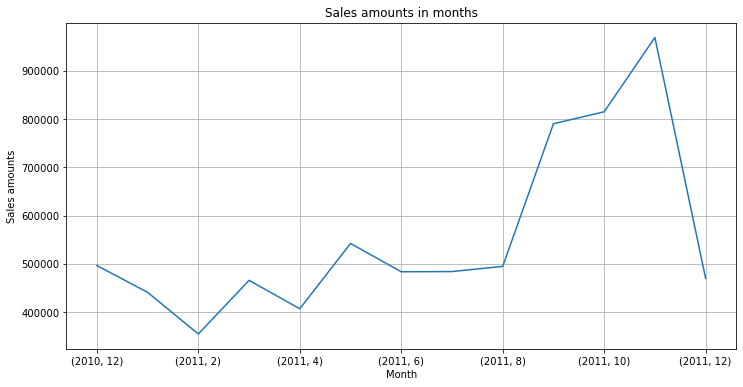

In [28]:
# Taking month and year from timestamp feature
pd.options.mode.chained_assignment = None

df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.month
df_clean['InvoiceYear'] = df_clean['InvoiceDate'].dt.year

# Plotting sales progress over time
plt.figure(figsize=(12,6))
df_clean.groupby(['InvoiceYear', 'InvoiceMonth'])['TotalPrice'].sum().plot(kind='line', label='sales', grid=True)
plt.title('Sales amounts in months')
plt.ylabel('Sales amounts')
plt.xlabel('Month');

Overall, the number of sales amount increases over the period, despite the fluctuative is observed from the beginning of 2011 to Q3 2011. The sales amount hits the peak in November 2011.

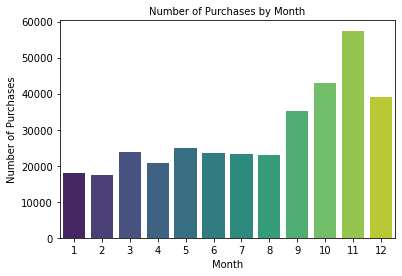

In [29]:
# Number of purchases by month
data = df_clean.groupby('InvoiceMonth')['InvoiceNo'].count()
ax = sns.barplot(x='InvoiceMonth', y='InvoiceNo', data=data.reset_index(), palette='viridis')
ax.set_title('Number of Purchases by Month', fontsize=10)
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases');

The highest number of purchases is in November. No wonder that there is Black Friday event this month. There must be numerous exciting offers and discounts that make customers willing to make purchases, even if they are not intended beforehand.

****

### **Recency, Frequency, Monetary (RFM) Analysis**

In [30]:
# Min max of date
print(f"Data period: \nStart: {df_clean['InvoiceDate'].min()}\nEnd: {df_clean['InvoiceDate'].max()}")

# Date for reference, addition 1 day from the last transaction date
reference_date = df_clean['InvoiceDate'].max() + dt.timedelta(days=1)
print(f'\nDate for reference: {reference_date}')

Data period: 
Start: 2010-12-01 00:00:00
End: 2011-12-09 00:00:00

Date for reference: 2011-12-10 00:00:00


**Calculating RFM metrics:**
- Aggregate the dataset on CustomerID.
- Perform aggregation for each unique customerID to calculate RFM values.

**Steps to generate each metric:**

1. **Recency:** Select the max invoice date of each customer (the latest transaction date is subtracted from the reference date. It results in the number of days since the last transaction.

2. **Frequency:** Count a unique invoice number has been generated for each customer.

3. **Monetary:** Take the sum of TotalPrice for each customer. It results in the total revenue generated per customer.

To calculate RFM, I will segment Recency, Frequency, and Monetary by quantile value (Q1, Q2, and Q3). Thus, in the end, there will be four groups for each metric, labeled as 1, 2, 3, 4.

In [31]:
# Calculate each metric
df_rfm = df_clean.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
                                            'InvoiceNo': lambda x: len(x.unique()), # Frequency
                                            'TotalPrice': lambda x: x.sum()})

In [32]:
# Rename the columns
df_rfm.rename(columns={'InvoiceDate':'Recency',
                        'InvoiceNo':'Frequency',
                        'TotalPrice':'Monetary'}, inplace=True)

In [33]:
df_rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,3,11,4196.01
12748.0,1,208,32202.69
12749.0,4,5,4090.88
12820.0,4,4,942.34
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [34]:
df_rfm.describe()

,Recency,Frequency,Monetary
count,3919.000000,3919.000000,3919.000000
mean,92.846900,4.244705,1840.662900
std,99.681143,7.190124,7409.673248
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,298.055000
50%,51.000000,2.000000,643.900000
75%,143.500000,5.000000,1564.645000
max,374.000000,208.000000,259657.300000


In [35]:
df_rfm[df_rfm['Frequency'] == 208]

,Recency,Frequency,Monetary
CustomerID,,,
12748.0,1,208,32202.69


**Recency segmentation**

In [36]:
# Recency segmentation using quartile
df_rfm['R'] = pd.qcut(df_rfm['Recency'], q=4, labels=[4, 3, 2, 1])

In [37]:
# Calculate Q1, Q2, Q3 of recency
df_rfm['Recency'].quantile([0.25, 0.5, 0.75])

0.25     18.0
0.50     51.0
0.75    143.5
Name: Recency, dtype: float64

In [38]:
# Group by the R segments
df_R = df_rfm.groupby(['R']).agg(TotalCustomer=('R', 'count')).reset_index(drop=False)

# Rename the R segments
df_R.loc[df_R['R'] == 1, 'R_group'] = 'Inactive'
df_R.loc[df_R['R'] == 2, 'R_group'] = 'Fairly Active'
df_R.loc[df_R['R'] == 3, 'R_group'] = 'Active'
df_R.loc[df_R['R'] == 4, 'R_group'] = 'Very Active'

# Calculate the R_group percentage
df_R['R_Percentage'] = round(df_R['TotalCustomer']/df_R['TotalCustomer'].sum()*100, 2)

# Reorder the columns
df_R = df_R[['R', 'R_group', 'TotalCustomer', 'R_Percentage']]
df_R

,R,R_group,TotalCustomer,R_Percentage
0,4,Very Active,1003,25.59
1,3,Active,969,24.73
2,2,Fairly Active,967,24.67
3,1,Inactive,980,25.01


**Notes:**

1. *Inactive:* Recency is greater than 143 days.
2. *Fairly Active:* Recency is between 52 and 143 days (up to almost five months).
3. *Active:* Recency is between 19 and 51 days.
4. *Very Active:* Recency is less than or equal to 18 days.

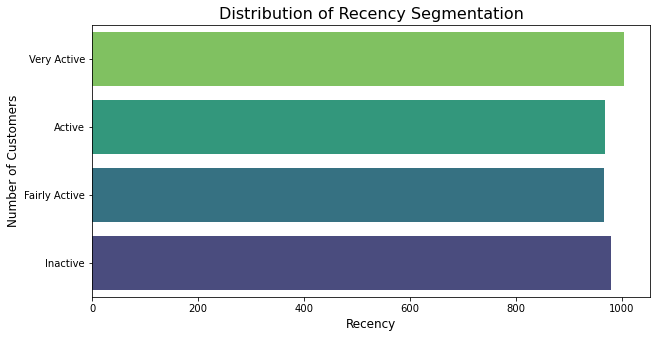

In [39]:
# Distribution of recency segmentation
plt.figure(figsize=(10, 5))
sns.barplot(y='R_group', x='TotalCustomer', data=df_R, palette='viridis_r')
plt.title('Distribution of Recency Segmentation', fontsize=16)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

**Key Takeaways**

Based on the graph above, most customers are in the 'Very Active' segment (25.59%), despite the discrepancy with the other segments being not too large. It can be said that many customers are actively making another transaction less than 18 days since their last transaction. 

**Frequency Segmentation**

In [40]:
df_rfm['Frequency'].quantile([0.25, 0.5, 0.75])

0.25    1.0
0.50    2.0
0.75    5.0
Name: Frequency, dtype: float64

In [41]:
# Frequency segmentation using quartile
df_rfm['F'] = pd.qcut(df_rfm['Frequency'], q=5, labels=[1, 2, 3, 4], duplicates='drop')
df_rfm['F'].value_counts()

1    2097
3     727
4     632
2     463
Name: F, dtype: int64

In [42]:
# Group by the F segments
df_F = df_rfm.groupby(['F']).agg(TotalCustomer=('F', 'count')).reset_index(drop=False)

# Rename the F segments
df_F.loc[df_F['F'] == 1, 'F_group'] = 'Rarely'
df_F.loc[df_F['F'] == 2, 'F_group'] = 'Occasionally'
df_F.loc[df_F['F'] == 3, 'F_group'] = 'Frequently'
df_F.loc[df_F['F'] == 4, 'F_group'] = 'Very Frequently'

# Calculate the F_group percentage
df_F['F_Percentage'] = round(df_F['TotalCustomer']/df_F['TotalCustomer'].sum()*100, 2)

# Reorder the columns
df_F = df_F[['F', 'F_group', 'TotalCustomer', 'F_Percentage']]
df_F

,F,F_group,TotalCustomer,F_Percentage
0,1,Rarely,2097,53.51
1,2,Occasionally,463,11.81
2,3,Frequently,727,18.55
3,4,Very Frequently,632,16.13


**Notes:**

1. *Rarely:* Frequency is equal to 1 to 2 times.
2. *Occasionally:* Frequency is equal to 3 times.
3. *Frequently:* Frequency in between 4 and 6 times.
4. *Very Frequently:* Frequency is greater than 6 times.

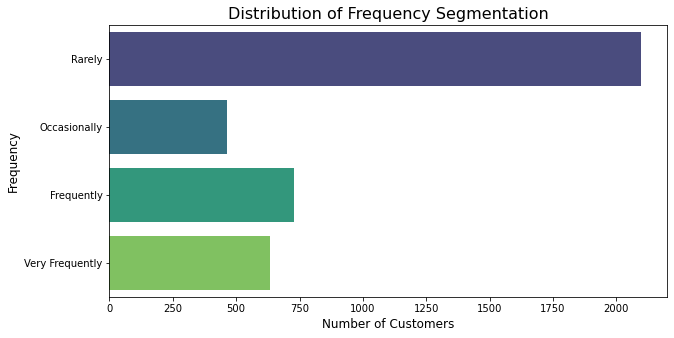

In [43]:
# Distribution of frequency segmentation
plt.figure(figsize=(10, 5))
sns.barplot(y='F_group', x='TotalCustomer', data=df_F, palette='viridis')
plt.title('Distribution of Frequency Segmentation', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

**Key Takeaways**

Most of the customers are in the 'Rarely' segment, which accounts for about 53.51% of the total customer. In other words, most customers made transactions only 1 or 2 times.

**Monetary Segmentation**

In [44]:
# Monetary segmentation using quartile
df_rfm['M'] = pd.qcut(df_rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

In [45]:
# Calculate Q1, Q2, Q3 of monetary
df_rfm['Monetary'].quantile([0.25, 0.5, 0.75])

0.25     298.055
0.50     643.900
0.75    1564.645
Name: Monetary, dtype: float64

In [46]:
# Group by the M segments
df_M = df_rfm.groupby(['M']).agg(TotalCustomer=('M', 'count')).reset_index(drop=False)

# Rename the F segments
df_M.loc[df_M['M'] == 1, 'M_group'] = 'Low'
df_M.loc[df_M['M'] == 2, 'M_group'] = 'Medium'
df_M.loc[df_M['M'] == 3, 'M_group'] = 'High'
df_M.loc[df_M['M'] == 4, 'M_group'] = 'Special'

# Calculate the F_group percentage
df_M['M_Percentage'] = round(df_M['TotalCustomer']/df_M['TotalCustomer'].sum()*100, 2)

# Reorder the columns
df_M = df_M[['M', 'M_group', 'TotalCustomer', 'M_Percentage']]
df_M

,M,M_group,TotalCustomer,M_Percentage
0,1,Low,980,25.01
1,2,Medium,980,25.01
2,3,High,979,24.98
3,4,Special,980,25.01


**Notes:**

1. *Low:* Monetary value is less than or equal to £298.05
2. *Medium:* Monetary value in between 298.06 and £643.9
3. *High:* Monetary value in between £644 and £1564.645
4. *Special:* Monetary value is greater than £1564.645

In [47]:
df_rfm

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12747.0,3,11,4196.01,4,4,4
12748.0,1,208,32202.69,4,4,4
12749.0,4,5,4090.88,4,3,4
12820.0,4,4,942.34,4,3,3
...,...,...,...,...,...,...
18280.0,278,1,180.60,1,1,1
18281.0,181,1,80.82,1,1,1
18282.0,8,2,178.05,4,1,1


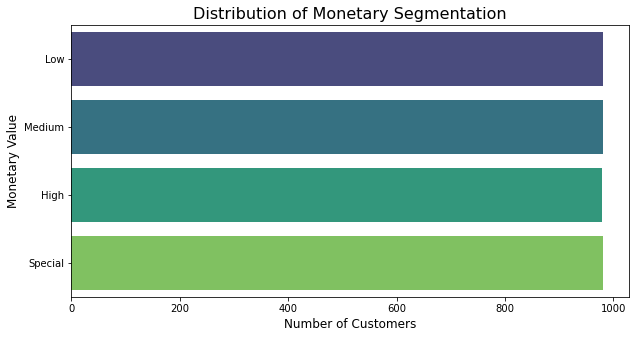

In [48]:
# Distribution of monetary segmentation
plt.figure(figsize=(10, 5))
sns.barplot(y='M_group', x='TotalCustomer', data=df_M, palette='viridis')
plt.title('Distribution of Monetary Segmentation', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Monetary Value', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

**Key Takeaways**

Surprisingly, the customers in the UK market are segmented with a similar ratio. 2940 customers are evenly distributed in the low, medium, and special segments, with 980 in each segment. While the 'high' segment is only one point difference.

By knowing this monetary value distribution, surely we can take an appropriate marketing approach for each segment.

****

**Combine the RFM Score**

To obtain RFM segmentation, we can combine the recency, frequency, and monetary of each customerID to be a unique string. For instance, if R = 1, F = 2, and M = 3, then RFM segment would be 1 + 2 + 3 = 123. On the other hand, for the RFM score, we can add the value of R, F, and M. From the previous example, the RFM score would be 6.

In [49]:
# Calculate RFMSegment and RFMScore
df_rfm['RFMSegment'] = df_rfm['R'].astype('string') + df_rfm['F'].astype('string') + df_rfm['M'].astype('string')
df_rfm['RFMScore'] = df_rfm['R'].astype('int') + df_rfm['F'].astype('int') + df_rfm['M'].astype('int') 
df_rfm

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12747.0,3,11,4196.01,4,4,4,444,12
12748.0,1,208,32202.69,4,4,4,444,12
12749.0,4,5,4090.88,4,3,4,434,11
12820.0,4,4,942.34,4,3,3,433,10
...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,1,1,1,111,3
18281.0,181,1,80.82,1,1,1,111,3
18282.0,8,2,178.05,4,1,1,411,6


The higher the RFMScore, the more valuable the customer is. The best combination is where RFMSegment is 444 so that the RFMScore would be 12.

**Customer Segmentation by RFM method**

In [50]:
# Grouping customers by RFMScore
df_rfm.groupby('RFMScore').agg({
    'Recency':'mean', 
    'Frequency':'mean', 
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
            mean      mean     mean count
RFMScore                                 
3         260.52      1.13   163.70   452
4         180.29      1.27   312.75   533
5          95.86      1.50   424.32   525
6          69.39      1.83   757.41   464
7          57.13      2.49   929.09   371
8          49.39      3.32  1159.48   298
9          47.74      4.71  2147.26   315
10         27.36      5.56  2038.93   300
11         19.52      8.25  3542.52   283
12          7.46     16.97  9041.93   378

According to the result above, we can divide customers into four main segments, which are:

|Segment|RFM Score|
|---|---|
|Bronze|3-5|
|Silver|6-8|
|Gold|9-11|
|Platinum|12|

In [51]:
# Customer segmentation
def customer_segmentation(i):
    if i <= 5:
        return 'Bronze'
    elif i <=8:
        return 'Silver'
    elif i <=11:
        return 'Gold'
    else:
        return 'Platinum'

df_rfm['CustomerSegment'] = df_rfm['RFMScore'].apply(customer_segmentation)

In [52]:
# Customer segmentation mean of each segment
cust_agg = df_rfm.groupby('CustomerSegment').agg({
    'Recency' : 'mean',
    'Frequency' : 'mean',
    'Monetary' : 'mean',
    'RFMSegment' : 'count'
}).round(2).sort_values(by='RFMSegment')

cust_agg

,Recency,Frequency,Monetary,RFMSegment
CustomerSegment,,,,
Platinum,7.46,16.97,9041.93,378
Gold,32.04,6.11,2550.78,898
Silver,60.11,2.44,919.38,1133
Bronze,174.95,1.31,306.93,1510


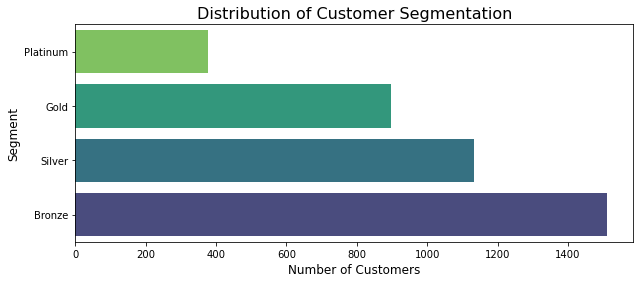

In [53]:
# Distribution of customer segmentation
plt.figure(figsize=(10, 4))
sns.countplot(y='CustomerSegment', data=df_rfm, palette='viridis_r', order = cust_agg['RFMSegment'].index)
plt.title('Distribution of Customer Segmentation', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

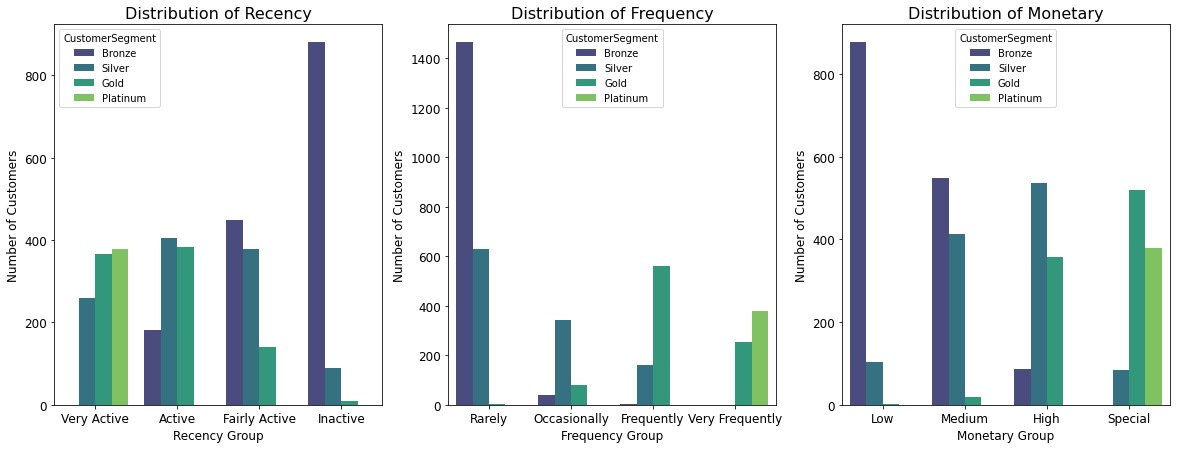

In [54]:
# Visualization of customer segments vs RFM
segment = ['Bronze', 'Silver', 'Gold', 'Platinum']

plt.figure(figsize=(20, 7))

plt.subplot(131)
sns.countplot(x='R', hue='CustomerSegment', data=df_rfm, hue_order=segment, palette='viridis')
plt.title('Distribution of Recency', fontsize=16)
plt.xlabel('Recency Group', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(np.arange(4), ['Very Active', 'Active', 'Fairly Active', 'Inactive'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(132)
sns.countplot(x='F', hue='CustomerSegment', data=df_rfm, hue_order=segment, palette='viridis')
plt.title('Distribution of Frequency', fontsize=16)
plt.xlabel('Frequency Group', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(np.arange(4), ['Rarely', 'Occasionally', 'Frequently', 'Very Frequently'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(133)
sns.countplot(x='M', hue='CustomerSegment', data=df_rfm, hue_order=segment, palette='viridis')
plt.title('Distribution of Monetary',fontsize=16)
plt.xlabel('Monetary Group', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(np.arange(4), ['Low', 'Medium', 'High', 'Special'], fontsize=12)
plt.yticks(fontsize=12);

In [55]:
# Check unique string of RFMScore for each segment
print('Bronze', df_rfm[df_rfm['CustomerSegment'] == 'Bronze'].sort_values(by='RFMScore')['RFMSegment'].unique(), '\n')
print('Silver', df_rfm[df_rfm['CustomerSegment'] == 'Silver'].sort_values(by='RFMScore')['RFMSegment'].unique(), '\n')
print('Gold', df_rfm[df_rfm['CustomerSegment'] == 'Gold'].sort_values(by='RFMScore')['RFMSegment'].unique(), '\n')
print('Platinum', df_rfm[df_rfm['CustomerSegment'] == 'Platinum'].sort_values(by='RFMScore')['RFMSegment'].unique())

Bronze <StringArray>
['111', '112', '211', '121', '113', '311', '212', '131', '221', '122']
Length: 10, dtype: string 

Silver <StringArray>
['114', '312', '213', '123', '411', '222', '321', '132', '231', '412', '313',
 '232', '421', '214', '322', '223', '124', '133', '331', '323', '233', '422',
 '431', '224', '413', '314', '332', '134', '143']
Length: 29, dtype: string 

Gold <StringArray>
['423', '414', '333', '234', '324', '144', '243', '432', '441', '334', '244',
 '433', '343', '424', '434', '443', '344']
Length: 17, dtype: string 

Platinum <StringArray>
['444']
Length: 1, dtype: string


To better visualize the relationship between Recency, Frequency, and Monetary of each customer segment, we can plot them into scatter plots.

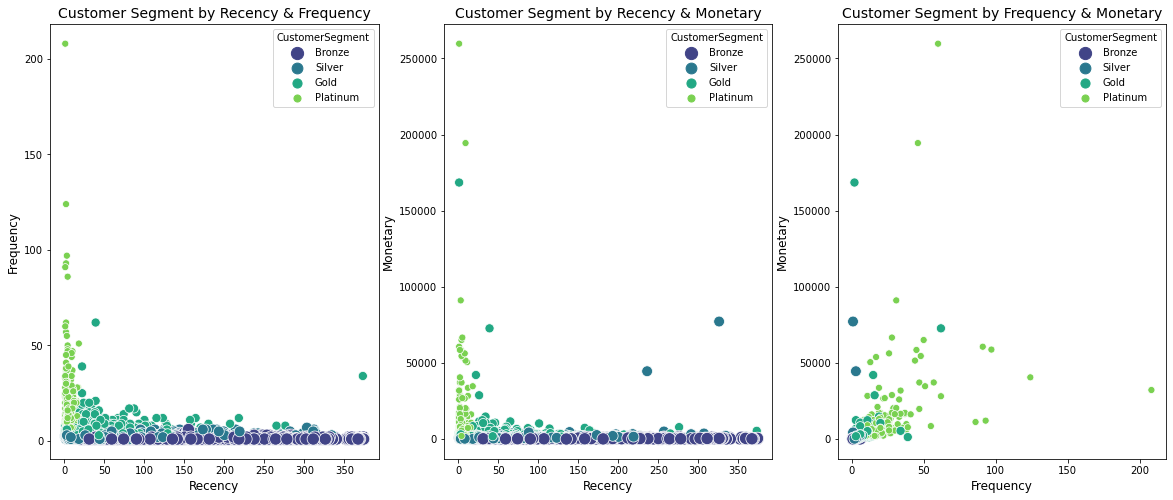

In [56]:
# Scatter plot of RFM segmentation
plt.figure(figsize=(20, 8))
plt.subplot(131)
sns.scatterplot(x='Recency', y='Frequency', hue='CustomerSegment', data=df_rfm, 
                size='CustomerSegment', sizes=(50, 150), size_order=segment, 
                hue_order=segment, palette='viridis')
plt.title('Customer Segment by Recency & Frequency', fontsize=14)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(132)
sns.scatterplot(x='Recency', y='Monetary', hue='CustomerSegment', data=df_rfm, 
                size='CustomerSegment', sizes=(50, 150), size_order=segment,
                hue_order=segment, palette='viridis')
plt.title('Customer Segment by Recency & Monetary', fontsize=14)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Monetary', fontsize=12)

plt.subplot(133)
sns.scatterplot(x='Frequency', y='Monetary', hue='CustomerSegment', data=df_rfm, 
                size='CustomerSegment', sizes=(50, 150), size_order=segment,
                hue_order=segment, palette='viridis')
plt.title('Customer Segment by Frequency & Monetary', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Monetary', fontsize=12);

**Key Takeaways**

**1. Platinum**
   - The best group of customers with recent transactions, mostly less than 18 days ago.
   - Frequently makes purchases, at least have made 13 times transactions.
   - Have spent the highest amount of transactions, at least more than £644.

**2. Gold**
   - Customers with a combination of low recency (recent transaction), mostly not more than 51 days ago, medium to high frequency and monetary value.
  
**3. Silver**
   - Combination of some characteristics of customer:
     - Customers with low to medium frequency and monetary value.
     - Some are new customers who purchased recently and spent a high amount.
     - Some customers purchased frequently and spent quite a lot, but it has been a long time since their last transaction.

**4. Bronze**
   - Customers who have not made a transaction for a long time, overall with low to medium frequency but the least of total sum transactions.

****

### **Action Plan Recommendation**

**1. Platinum**

Since platinum is the best group of customers, this group generates a high percentage of overall revenues. Therefore, we have to maintain a great relationship with this group of customers and make them feel appreciated and valued. We can give them a loyalty program or reward point as a treatment. Furthermore, new products recommendation, offer of luxury goods, and another kind of cross or upselling strategy is worth doing to this group.

**2. Gold**

This group has a little bit lower than platinum group characteristics, consisting of customers who spent a lot of money. The main difference with the platinum group is in the recency value. However, they have a high potential to enter the platinum customer segment. Thus, we can give them a loyalty program or reward point, an offer of luxury goods, and a regular limited attractive offer with a discount or cashback voucher via email to trigger them to make more purchases.

**3. Silver**

This group consists of various customers characteristics, including new-joined customers who purchased a high amount. Even though they have been a while since their last transaction, they show promising signs as the value of their purchase is quite significant. We can regularly give discounts and cashback vouchers, and another kind of reactivation and retention strategy such as limited offers via email and ads to maintain relationships.

**4. Bronze**

This group needs attention and requires activation. They made some purchases, but they have not back to us. Was it an inconvenient customer experience? We can treat them with a reactivation strategy, such as an email campaign to make them aware and ask them to give feedback to us. If they provide us with feedback, we can know their preferences and why they are inactive. 


****

### **End Notes**

By performing RFM segmentation, we can answer some of the questions that are useful for our business improvement, such as:
- Who are the best customers?
- Who are the loyal customers?
- Which are customers who tend to churn?
- Who are the lost customers you need to pay much attention to?
- Which customers have the potential to be converted into more loyal customers?

And so on.

**For instances**

- Who are the best customers?

In [57]:
# RFMSegment = 444
df_rfm[df_rfm['RFMSegment']=='444'].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore,CustomerSegment
CustomerID,,,,,,,,,
18102.0,1,60,259657.30,4,4,4,444,12,Platinum
17450.0,9,46,194390.79,4,4,4,444,12,Platinum
17511.0,3,31,91062.38,4,4,4,444,12,Platinum
16684.0,5,28,66653.56,4,4,4,444,12,Platinum
13694.0,4,50,65039.62,4,4,4,444,12,Platinum


- Who are the loyal customers?

In [58]:
# Customers with high frequency value
df_rfm[df_rfm['F'] >= 3 ].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore,CustomerSegment
CustomerID,,,,,,,,,
18102.0,1,60,259657.30,4,4,4,444,12,Platinum
17450.0,9,46,194390.79,4,4,4,444,12,Platinum
17511.0,3,31,91062.38,4,4,4,444,12,Platinum
16029.0,39,62,72708.09,3,4,4,344,11,Gold
16684.0,5,28,66653.56,4,4,4,444,12,Platinum
13694.0,4,50,65039.62,4,4,4,444,12,Platinum
15311.0,1,91,60632.75,4,4,4,444,12,Platinum
13089.0,3,97,58762.08,4,4,4,444,12,Platinum
17949.0,2,45,58510.48,4,4,4,444,12,Platinum


- Which are customers who tend to churn?

In [59]:
# Customers with high F and M value, but low R value
df_rfm[df_rfm['R'] == 1 ].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore,CustomerSegment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,Silver
15749.0,236,3,44534.30,1,2,4,124,7,Silver
13093.0,276,8,7832.47,1,4,4,144,9,Gold
12980.0,158,9,7374.90,1,4,4,144,9,Gold
16553.0,164,12,5719.82,1,4,4,144,9,Gold


- Who are the lost customers you need to pay much attention to?

In [60]:
# Customers with low R value but high F and M value
df_rfm[(df_rfm['R'] == 1) & (df_rfm['F'] >= 2) & (df_rfm['M'] >= 2)].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore,CustomerSegment
CustomerID,,,,,,,,,
15749.0,236,3,44534.30,1,2,4,124,7,Silver
13093.0,276,8,7832.47,1,4,4,144,9,Gold
12980.0,158,9,7374.90,1,4,4,144,9,Gold
16553.0,164,12,5719.82,1,4,4,144,9,Gold
17850.0,373,34,5391.21,1,4,4,144,9,Gold


- Which customers have the potential to be converted into more loyal customers?

In [61]:
# Customers with R, F, & M value = 3
df_rfm[(df_rfm['R'] == 3) & (df_rfm['F'] == 3) & (df_rfm['M'] == 3)].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,R,F,M,RFMSegment,RFMScore,CustomerSegment
CustomerID,,,,,,,,,
13313.0,23,5,1555.32,3,3,3,333,9,Gold
13634.0,34,5,1547.36,3,3,3,333,9,Gold
13107.0,45,4,1531.62,3,3,3,333,9,Gold
15530.0,22,4,1497.31,3,3,3,333,9,Gold
18016.0,33,5,1477.66,3,3,3,333,9,Gold
